In [14]:
#now move to more complex and large neural networks such as RNN and GRU
#RNN not very optimizable
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
(torch.randn(1000)*0.2).std()
#num you multiply by becomes std

tensor(0.1947)

In [16]:
(5/3) / (30**0.5)
#good gain for W1 (we approximated 0.2)

0.3042903097250923

tensor(0.0053) tensor(1.0095)
tensor(0.0040) tensor(1.0032)


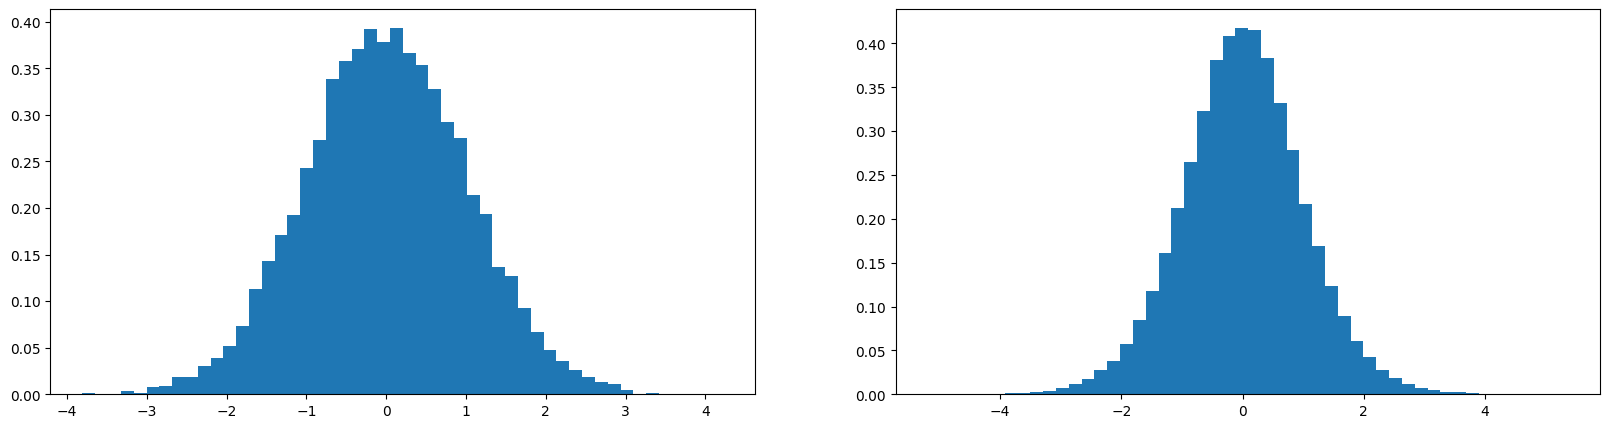

In [17]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5 #common practice for normalizing weights
#tanh squeezes in the tails
#to fight squeeze to keep gausian we need gain

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122);
plt.hist(y.view(-1).tolist(), 50, density=True);
#gaussian std expanding - dont want that for nn

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #from paper
                   #f_in   f_out                                            f_in        
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


- when tanh(x)=0 out.grad just passes through as the same. the gradient in tanh can only ever decrease. gradients flowing through tanh will just get destroyed
#Batch normalization
- made it possible to train deep nn reliably

In [ ]:
# ub = hpreact.mean(0, keepdim=True) #mean over columns
# s2b = hpreact.std(0, keepdim=True) #std over columns
# norm =(hpreact - ub)/(s2b) + epsilon(to prevent dividing by zero)
# yi = bngain * norm + bnbias
# #torch.sum(yi, 0)

Summary of bn layer
-used to control the statistics of activiations in the nn
-usually placed after a linear layer or convolutional layer
-has parameters for gain and bias
-parameters trained using backpropogation
-has 2 buffers
    - mean and std 
    - running mean and std
    - trained using update during training
-calculating mean and std of activations that are feeding into the batchnorm layer over that batch
-centering batch to be gaussian
-offsetting and scaling by the learned bias and gain
-keeps track of mean and std of elements and maintain running mean and std
    -used for inference

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation #want them to be roughly gaussian so normalize them
  #b1 is just subtracted out later due to bmbias (b1.grad will be zero)
  #standardization is differentiable
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)

  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  #want it to be roughly gaussian but only initially
  #dont want it to be forced to be gaussian
  #therefore we need to scale it by some gain and shift by a bias

  with torch.no_grad():
    bmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) #hidden layer
  logits = h @ W2 + b2 #getting extreme values which is throwing off the loss because of random b2
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break
#high loss shows network is very confidently wrong

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


order:
-weight layer
-normalization layer
-nonlinearity layer(hidden)

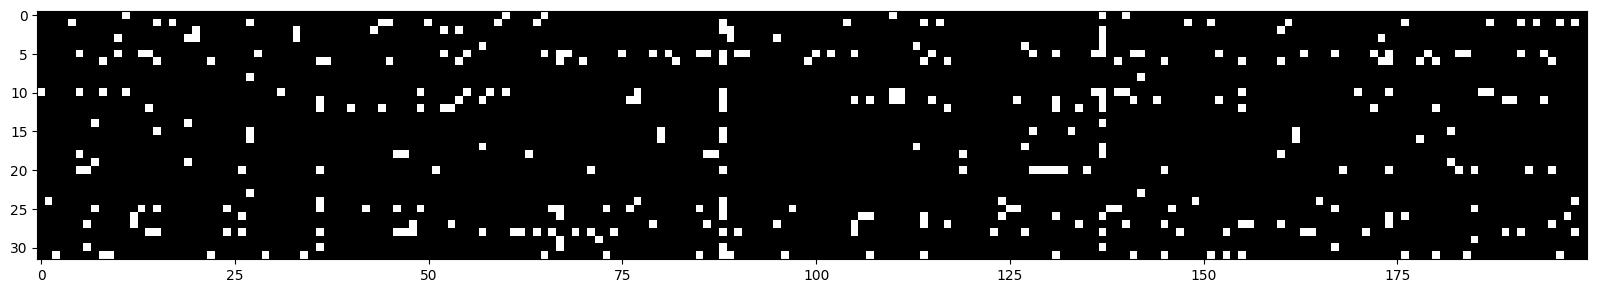

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation = 'nearest')
#black shows gradients that are destroyed by tanh
#shouldnt have any columns that are all white because that means it is a dead neuron
#means that neuron will never learn 

In [22]:
#4d example 
#logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
# logits = torch.randn(4)
# probs = torch.softmax(logits, dim=0)
# loss = -probs[2].log()
# logits, probs, loss

In [23]:
-torch.tensor(1/27.0).log() #loss we can expect in uniform distribution

tensor(3.2958)

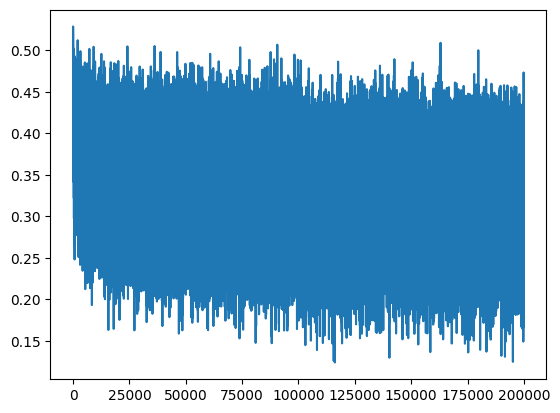

In [24]:
plt.plot(lossi)

In [25]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  # bnmean = hpreact.mean(0, keepdim=True)
  # bnstd = hpreact.std(0, keepdim=True)
  #this can be estimated in a running manner during training

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1 
  hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.9213240146636963
val 2.9490609169006348


-nn expects batches as an input

In [28]:
#sampling from the model
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] #(1, block_size, n_embd)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    #sample from the distribution
    ix = torch.multinomial(probs, num_samples=1,generator=g).item()
    #shift context window and track
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) #decode and print

dextdmi.
gluuskillistafnrvillistta.
sragfakshanna.
sashviusjussiyah.
simiszaddlyxussfprddn.
kamerkamsidly.
braviyrdhftlstifglivebvordlyss.
bswi.
blaysl.
pragatgh.
briezdicts.
zkmycern.
flyma.
kaikshbunabdvith.
khyl.
qly.
braylitaylissecklmarissamarlvarshbn.
proxkllptjannzelgprdh.
bryennksimimalbhtif.
bduwistammramsiemmarisharlusalcynzi.
